In [1]:
import sys
sys.path.append('../')

import logging
import os
import unittest

import numpy as np
import torch
import torchvision as tv
import matplotlib.pyplot as plt

from aad.attacks import FGSMContainer
from aad.basemodels import ModelContainerPT, get_model
from aad.datasets import DATASET_LIST, DataContainer
from aad.defences import FeatureSqueezing
from aad.utils import get_data_path, get_l2_norm, get_range, master_seed, swap_image_channel

%load_ext autoreload
%autoreload 2

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

In [2]:
SEED = 4096
BATCH_SIZE = 128
NAME = 'MNIST'
MAX_EPOCHS = 50
MODEL_FILE = os.path.join('..', 'save', 'MnistCnnV2_MNIST_e50.pt')
SQUEEZER_FILE = os.path.join('test', 'MnistCnnV2_MNIST_e50')
DATA_ROOT = os.path.join('..', 'data')
SQUEEZING_METHODS = ['median']

In [3]:
master_seed(SEED)

Model = get_model('MnistCnnV2')
model = Model()
logger.info('Starting %s data container...', NAME)
dc = DataContainer(DATASET_LIST[NAME], DATA_ROOT)
dc()
mc = ModelContainerPT(model, dc)
mc.load(MODEL_FILE)
accuracy = mc.evaluate(dc.x_test, dc.y_test)
logger.info('Accuracy on test set: %f', accuracy)

INFO:__main__:Starting MNIST data container...
INFO:aad.datasets.data_container:Train size: 60000 - Test size: 10000
INFO:aad.datasets.data_container:Successfully load data. Time to complete: 0m 3.763s
INFO:aad.basemodels.model_container_pt:Loaded model from ../save/MnistCnnV2_MNIST_e50.pt
INFO:__main__:Accuracy on test set: 0.990900


In [4]:
dc = mc.data_container
x_range = get_range(dc.x_train)
# Do not load pretrained parameters
squeezer = FeatureSqueezing(
    mc,
    clip_values=x_range,
    smoothing_methods=SQUEEZING_METHODS,
    bit_depth=8,
    sigma=0.1,
    kernel_size=3,
    pretrained=False,
)
squeezer.load(os.path.join('..', 'save', SQUEEZER_FILE))

INFO:aad.basemodels.model_container_pt:Loaded model from ../save/test/MnistCnnV2_MNIST_e50_median.pt


In [5]:
def imshow(tensor_grid, mean=0., std=1., title=None):
    assert isinstance(tensor_grid, torch.Tensor)
    assert len(tensor_grid.size()) == 4, \
        f'For a batch of images only, {tensor_grid.size()} '
    
    tensor_grid = tv.utils.make_grid(tensor_grid)
    grid = tensor_grid.numpy().transpose((1,2,0))
    grid = std * grid + mean
    grid = np.clip(grid, 0, 1)
    plt.imshow(grid)
    
    if title is not None:
        plt.title(title)
        
    plt.pause(0.001)

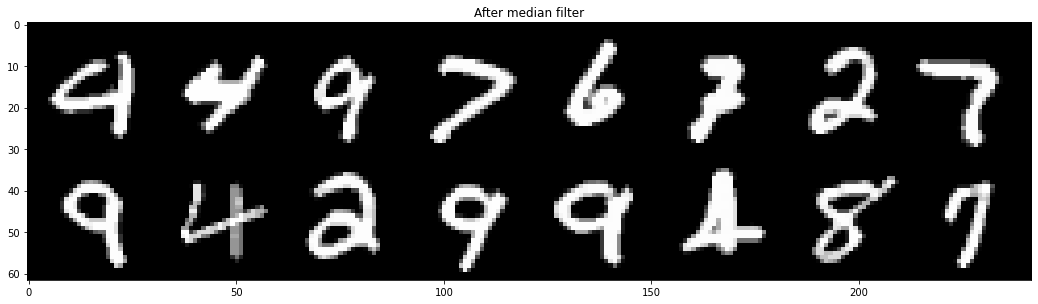

In [6]:
squeezing_model = squeezer.get_def_model_container('median')
x_train = squeezing_model.data_container.x_train
images = x_train[:16]

plt.figure(figsize=[18, 18])
imshow(torch.from_numpy(swap_image_channel(images)), title='After median filter')
plt.show()